# Potato Disease Prediction for AgroAI  
## Model 4: DenseNet
### Import Dependencies

In [ ]:
import tensorflow as tf
from PIL import Image
import cv2, pathlib
from tensorflow.keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import os
import shutil
import pickle
import tempfile
from sklearn.model_selection import train_test_split

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

Num GPUs Available:  1


### Load Images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/FINAL_PROJECT/potato.zip", 'r')
zip_ref.extractall('/content/data')
zip_ref.close()

In [ ]:
IMAGE_SIZE = 224
TARGET_SIZE = (IMAGE_SIZE, IMAGE_SIZE)
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
CHANNELS = 3
BATCH_SIZE = 16
INPUT_SHAPE2 = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

In [ ]:
# Set up the base directory
base_dir = "/content/data/potato"

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
            base_dir,
            labels = 'inferred',
            shuffle = True,
            image_size = (IMAGE_SIZE, IMAGE_SIZE),
            batch_size = BATCH_SIZE,
            color_mode = 'rgb'
)

Found 2144 files belonging to 3 classes.


In [ ]:
type(dataset)

tensorflow.python.data.ops.batch_op._BatchDataset

In [ ]:
#def resize_data(images, labels):
#    tf.print('Original shape -->', tf.shape(images))
#    SIZE = (224, 224)
#    return tf.image.resize(images, SIZE), labels

In [ ]:
#dataset = dataset.map(resize_data)

In [ ]:
classes = dataset.class_names
classes

['potato early blight', 'potato healthy', 'potato late blight']

In [ ]:
len(dataset)

134

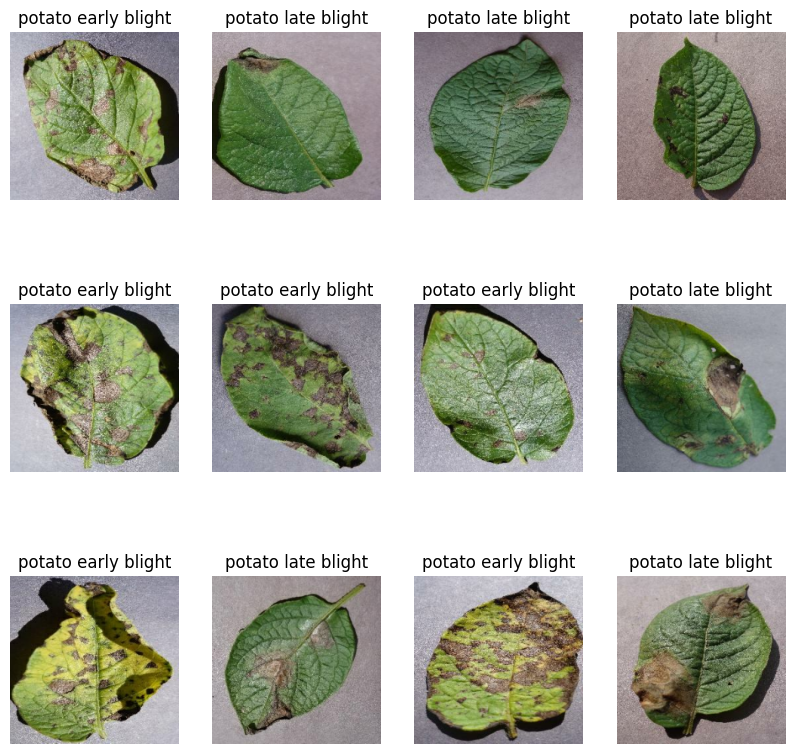

In [ ]:
plt.figure(figsize=(10,10))
for image_batch , label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(classes[label_batch[i]])
        plt.axis('off')

In [ ]:
len(dataset) * 16

2144

### Data Splitting

In [ ]:
def data_split(data, train_split = 0.8, val_split = 0.15, 
               test_split = 0.05, shuffle=True, shuffle_size = 10000):
    data_size = len(data)
    if shuffle:
        data = data.shuffle(shuffle_size, seed=8)
    
    train_size = int(train_split * data_size)
    val_size = int(val_split * data_size)
    
    train_ds = data.take(train_size)
    val_ds = data.skip(train_size).take(val_size)
    test_ds = data.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = data_split(dataset)

In [ ]:
print("Length of Training Dataset is",len(train_ds))
print("\nLength of Validation Dataset is",len(val_ds))
print("\nLength of Testing Dataset is",len(test_ds))

Length of Training Dataset is 107

Length of Validation Dataset is 20

Length of Testing Dataset is 7


### Image Augmentation

Since ImageDataGenerator is deprecated as of Tensorflow >=2.5, we can use the Keras Layers Experimental Preprocessing API to apply the image augmentations instead.

In [ ]:
train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
#def preprocessing(ds):
#  for images, labels in ds:
#    images /= 255.0

#  return tf.image.resize(images,[224,224]), tf.one_hot(labels, 3)

In [ ]:
#train_ds = preprocessing(train_ds)

In [ ]:
#val_ds = preprocessing(val_ds)

In [ ]:
#print(train_ds)

In [ ]:
type(train_ds)

tensorflow.python.data.ops.take_op._TakeDataset

In [ ]:
def resize(ds):
    resizing_rescaling = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.Resizing(224,224),
        tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255.0)
    ])

    return resizing_rescaling

In [ ]:
resizing_rescaling = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(224,224),
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255.0)
])

In [ ]:
def data_augmenter():
    data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.4),
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(-0.3, 0.3),
                                                                 width_factor=(-0.3, 0.3),
                                                                 fill_mode = 'nearest'),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=(-0.3, 0.3),
                                                                 width_factor=(-0.3, 0.3),
                                                                 fill_mode = 'nearest'),
    tf.keras.layers.experimental.preprocessing.RandomHeight(factor=(-0.3, 0.3),
                                                            interpolation = 'nearest'),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.9)
])

    return data_augmentation

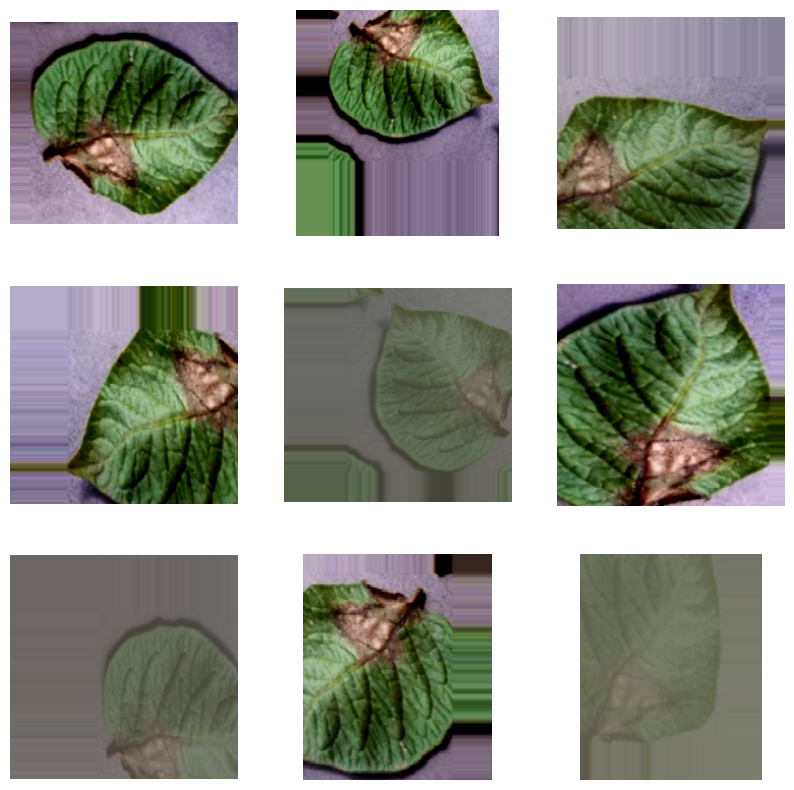

In [ ]:
data_augmentation = data_augmenter()

for image, _ in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [ ]:
data_augmentation = tf.keras.Sequential([
tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
tf.keras.layers.experimental.preprocessing.RandomRotation(0.4),
tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(-0.3, 0.3),
                                                             width_factor=(-0.3, 0.3),
                                                             fill_mode = 'nearest'),
tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=(-0.3, 0.3),
                                                             width_factor=(-0.3, 0.3),
                                                             fill_mode = 'nearest'),
tf.keras.layers.experimental.preprocessing.RandomHeight(factor=(-0.3, 0.3),
                                                        interpolation = 'nearest'),
tf.keras.layers.experimental.preprocessing.RandomContrast(0.9)
])

### Init Methods

In [ ]:
def conf_matrix(y_test, y_pred):
  cf_matrix = confusion_matrix(y_test, y_pred)

  ax = sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues')

  ax.set_title('Confusion Matrix with labels\n')
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ')
  ax.set_xticks()
  ax.xaxis.set_ticklabels(source_classes, rotation=45)
  ax.yaxis.set_ticklabels(source_classes, rotation=45)

  plt.show()

In [ ]:
saved_model_dir = "saved_model"
saved_model_his = "saved_model_history"
tflite_model_dir = "tflite_model"

if not(os.path.isdir(saved_model_dir)): os.mkdir(saved_model_dir)
if not(os.path.isdir(saved_model_his)): os.mkdir(saved_model_his)
if not(os.path.isdir(tflite_model_dir)): os.mkdir(tflite_model_dir)

In [ ]:
# save model method
def saved_model(modelname, model):
  export_path = os.path.join(saved_model_dir, modelname)
  if os.path.isdir(export_path):
    print('\nAlready saved a model, replace to new model\n')
    shutil.rmtree(export_path, ignore_errors=True)

  model.save(export_path)
  print("Export path: ", export_path)
  print(os.listdir(export_path))

# save model history method
def saved_model_history(modelname, history):
  with open(os.path.join(saved_model_his, modelname), 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [ ]:
# convert saved model to TFLite model
def tflite_model_convert(modelname, tflitedir):
  # Intialize the TFLite converter to load the SavedModel
  export_path = os.path.join(saved_model_dir, modelname)

  converter = tf.lite.TFLiteConverter.from_saved_model(export_path)

  # Set the optimization strategy in the converter 
  converter.optimizations = [tf.lite.Optimize.DEFAULT]

  # Use the tool to finally convert the model
  tflite_model = converter.convert()

  # Write TFLite model
  tflite_dir = os.path.join(tflite_model_dir, tflitedir)

  if os.path.isdir(tflite_dir):
    print('\nAlready saved a model, replace to new model\n')
    shutil.rmtree(tflite_dir, ignore_errors=True)

  os.mkdir(tflite_dir)

  tflite_file = os.path.join(tflite_dir, "leaf_{}.tflite".format(tflitedir.lower()))
  label_file = os.path.join(tflite_dir, "leaf_{}.txt".format(tflitedir.lower()))

  with open(tflite_file, "wb") as f:
      f.write(tflite_model)

  with open(label_file, 'w') as f:
      f.write('\n'.join(name_classes))

  print("Export path: ", tflite_dir)
  print(os.listdir(tflite_dir))

In [ ]:
# save all model with simplify function
def save_all_model(modelname, model, history):
  # save model
  saved_model(modelname, model)

  # save history as dict
  saved_model_history(modelname, history)

  # save best model
  #best_model = tf.keras.models.load_model('best_{}.h5'.format(modelname))
  #best_modelname = "BestMC_{}".format(modelname)
  #saved_model(best_modelname, best_model)
  # clear best model h5 format
 # os.remove('best_{}.h5'.format(modelname))

  # save tflite best model
  #tflite_model_convert(best_modelname, modelname)

### Model 4: DenseNet

In [ ]:
# Get a single batch from the dataset
batch = next(iter(train_ds))

input_data = batch[0]

# Print the shape of the data in the batch
print(input_data.shape)

(16, 224, 224, 3)


In [ ]:
len(classes)

3

In [ ]:
from tensorflow.keras.applications.densenet import DenseNet121

pre_trained_model = DenseNet121(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)


pre_trained_model.trainable = False

In [ ]:
preprocess_input = tf.keras.applications.densenet.preprocess_input

In [ ]:
inputs = tf.keras.Input(shape=INPUT_SHAPE)
x = preprocess_input(inputs)
#x = data_augmentation(x)
#x = mbnet_v2(x, training=False)
x = pre_trained_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation = 'relu')(x)
predict = tf.keras.layers.Dense(3, activation = 'softmax')(x)

model4 = tf.keras.Model(inputs = inputs, outputs = predict)

In [ ]:
model4.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                           

In [ ]:
class EarlyStoppingAtMaxAccuracy(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if(logs.get('accuracy')>=0.99):
            print("\nAccuracy is high so cancelling training!")
            self.model.stop_training = True


callbacks = EarlyStoppingAtMaxAccuracy()

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)

In [ ]:
model4.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics=['accuracy']
)

In [ ]:
history4 = model4.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=100,
    callbacks=[callbacks]
)

Epoch 1/100
107/107 [==============================] - 19s 91ms/step - loss: 0.2603 - accuracy: 0.8960 - val_loss: 0.0506 - val_accuracy: 0.9812
Epoch 2/100
107/107 [==============================] - 9s 73ms/step - loss: 0.1180 - accuracy: 0.9603 - val_loss: 0.0377 - val_accuracy: 0.9875
Epoch 3/100
107/107 [==============================] - 9s 72ms/step - loss: 0.0631 - accuracy: 0.9796 - val_loss: 0.0104 - val_accuracy: 0.9969
Epoch 4/100
107/107 [==============================] - 9s 74ms/step - loss: 0.0582 - accuracy: 0.9772 - val_loss: 0.0062 - val_accuracy: 1.0000
Epoch 5/100
107/107 [==============================] - 9s 73ms/step - loss: 0.0767 - accuracy: 0.9772 - val_loss: 0.0445 - val_accuracy: 0.9844
Epoch 6/100
107/107 [==============================] - ETA: 0s - loss: 0.0257 - accuracy: 0.9924
Accuracy is high so cancelling training!
107/107 [==============================] - 9s 73ms/step - loss: 0.0257 - accuracy: 0.9924 - val_loss: 0.0102 - val_accuracy: 0.9969


In [ ]:
model4.save('DenseNet121Model_Potato2.h5')

In [ ]:
score_train = model4.evaluate(train_ds)
score_valid = model4.evaluate(val_ds)
score_test = model4.evaluate(test_ds)

7/7 [==============================] - 1s 53ms/step - loss: 0.0144 - accuracy: 0.9911


In [ ]:
model4.save('DenseNet121Model_Potato.h5')

In [ ]:
acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']

loss = history4.history['loss']
val_loss = history4.history['val_loss']

In [ ]:
print("Accuracy: {}".format(acc[-1]))
print("Validation Accuracy: {}".format(val_acc[-1]))

print("Loss: {}".format(loss[-1]))
print("Validation Loss: {}".format(val_loss[-1]))

Accuracy: 0.9731308221817017
Validation Accuracy: 0.9906250238418579
Loss: 0.06532794237136841
Validation Loss: 0.042728714644908905


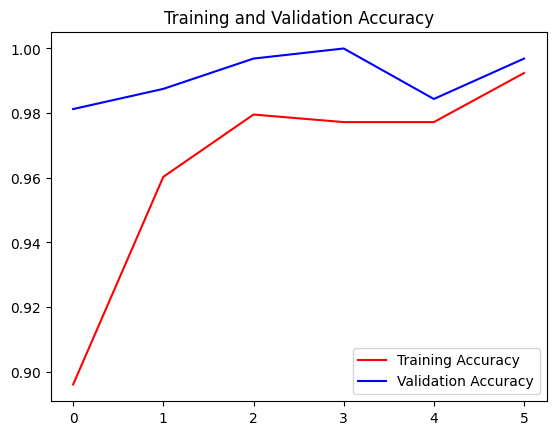

<Figure size 640x480 with 0 Axes>

In [ ]:
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

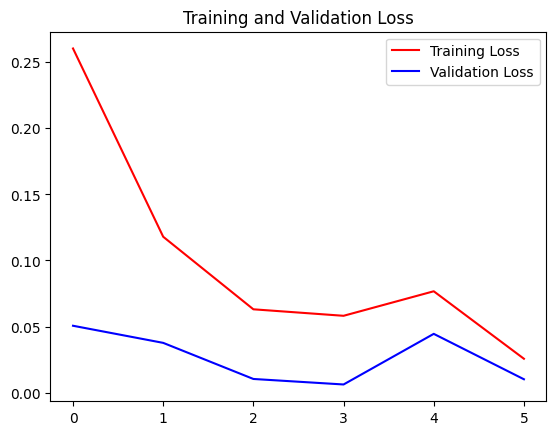

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc=0)
plt.figure()

plt.show()

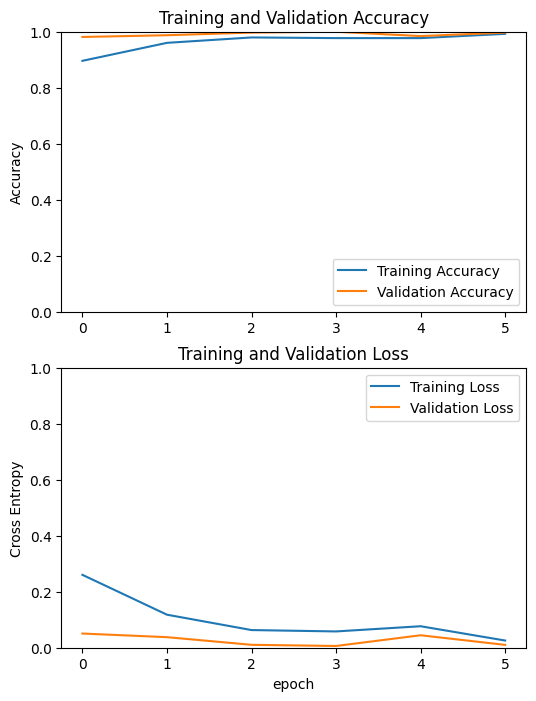

In [ ]:
plt.figure(figsize=(6, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.ylim([0,1.0])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

first image to predict
actual label: potato early blight
1/1 [==============================] - 2s 2s/step
predicted label: potato early blight


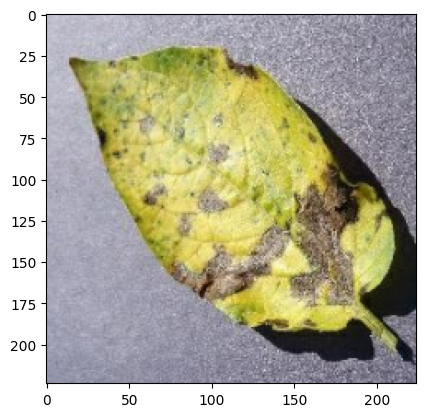

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",classes[first_label])
    
    batch_prediction = model4.predict(images_batch)
    print("predicted label:",classes[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict (img_array)
    predicted_class = classes[np.argmax(predictions[0])]
#     confidence = round(np.max(predictions[0]),2)
    confidence = round(100*(np.max(predictions[0])),2)

    return predicted_class, confidence

1/1 [==============================] - 0s 29ms/step


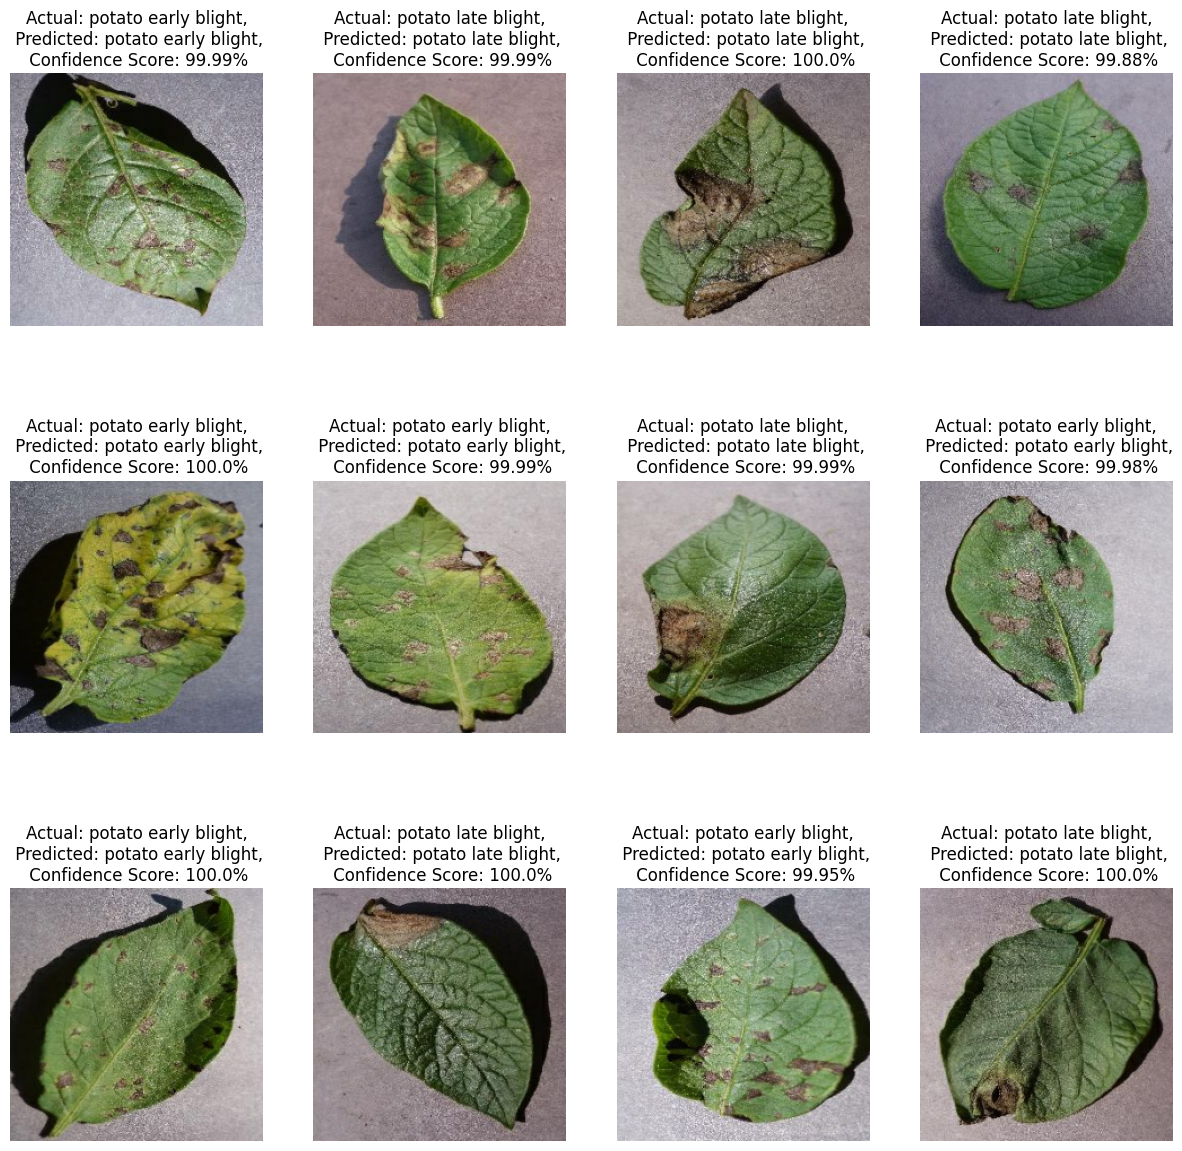

In [ ]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class , confidence = predict(model4,images[i].numpy())
        actual_class = classes[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence Score: {confidence}%")
        plt.axis("off")

In [ ]:
pred_class = []
act_class = []
for images,labels in test_ds:
    for i in range(len(test_ds)):
        #ax = plt.subplot(3,4,i+1)
        #plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class , confidence = predict(model4,images[i].numpy())
        actual_class = classes[labels[i]]

        pred_class.append(predicted_class)
        act_class.append(actual_class)

1/1 [==============================] - 0s 28ms/step


In [ ]:
act_class

['potato late blight',
 'potato late blight',
 'potato early blight',
 'potato late blight',
 'potato healthy',
 'potato healthy',
 'potato late blight',
 'potato late blight',
 'potato early blight',
 'potato late blight',
 'potato late blight',
 'potato late blight',
 'potato healthy',
 'potato late blight',
 'potato healthy',
 'potato early blight',
 'potato early blight',
 'potato early blight',
 'potato early blight',
 'potato late blight',
 'potato late blight',
 'potato late blight',
 'potato late blight',
 'potato early blight',
 'potato late blight',
 'potato healthy',
 'potato late blight',
 'potato early blight',
 'potato late blight',
 'potato late blight',
 'potato late blight',
 'potato late blight',
 'potato healthy',
 'potato healthy',
 'potato late blight',
 'potato early blight',
 'potato late blight',
 'potato late blight',
 'potato early blight',
 'potato early blight',
 'potato late blight',
 'potato late blight',
 'potato late blight',
 'potato late blight',
 'pot

In [ ]:
cm = confusion_matrix(act_class, pred_class, labels=classes)

In [ ]:
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(16,5))
    ax = sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    ax.set_title('Confusion Matrix with labels\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ax.xaxis.set_ticklabels(classes, rotation=45)
    ax.yaxis.set_ticklabels(classes, rotation=45)

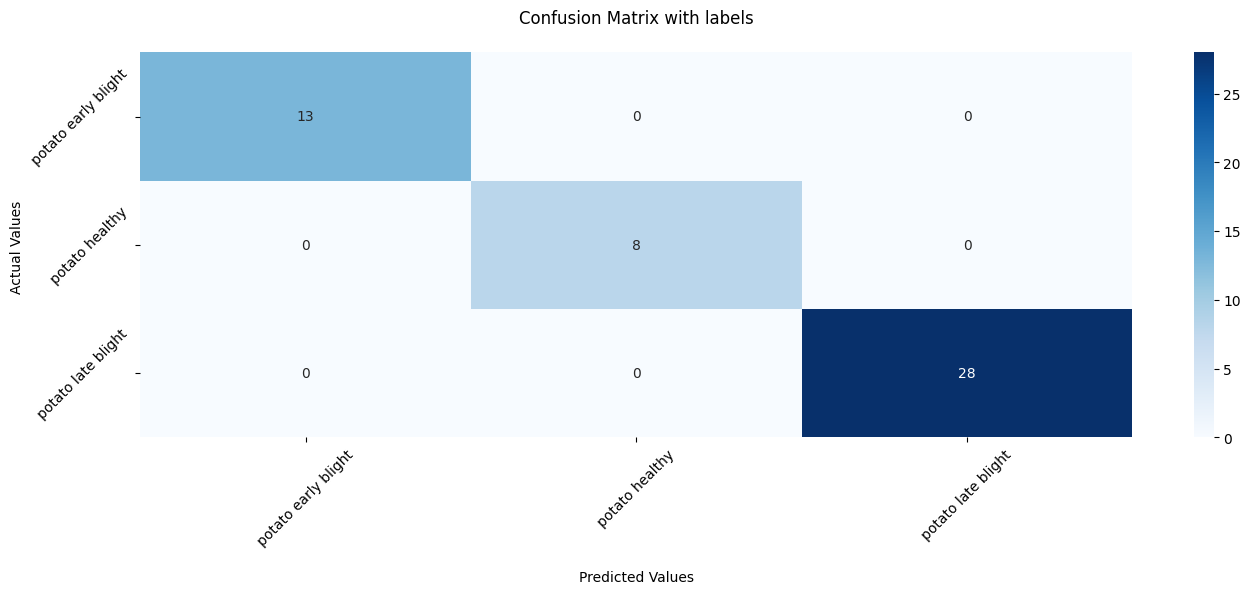

In [ ]:
plot_confusion_matrix(cm = cm, classes = classes)

In [ ]:
def saved_model(model_path, modelname, model):
  export_path = os.path.join(model_path, modelname)
  model.save(export_path)
  #tf.saved_model.save(model, export_path)
  print("Export path: ", export_path)
  print(os.listdir(export_path))

# function to saved_model_history
def saved_model_history(model_path, modelname, history):
  with open(os.path.join(model_path, modelname), 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

# function to save tflite
def tflite_model_convert(model_path, tflite_path, modelname):

  # Intialize the TFLite converter to load the SavedModel
  export_path = os.path.join(model_path, modelname)

  converter = tf.lite.TFLiteConverter.from_saved_model(export_path)

  # Set the optimization strategy in the converter 
  converter.optimizations = [tf.lite.Optimize.DEFAULT]

  # Use the tool to finally convert the model
  tflite_model = converter.convert()

  # Write TFLite model
  tflite_dir = os.path.join(tflite_path, "{}".format(modelname))

  os.mkdir(tflite_dir)

  tflite_file = os.path.join(tflite_dir, "{}.tflite".format(modelname))
  
  label_file = os.path.join(tflite_dir, "{}.txt".format(modelname))

  with open(tflite_file, "wb") as f:
      f.write(tflite_model)

  with open(label_file, 'w') as f:
      f.write('\n'.join(classes))

  print("Export path: ", tflite_dir)
  print(os.listdir(tflite_dir))

In [ ]:
model_path = "/content/drive/MyDrive/FINAL_PROJECT/POTATO/DenseNet/saved_model"
os.makedirs(model_path, exist_ok=True)
modelname = "DennseNet_Potato"
saved_model(model_path, modelname, model4)

Export path:  /content/drive/MyDrive/FINAL_PROJECT/POTATO/DenseNet/saved_model/DennseNet_Potato
['variables', 'assets', 'fingerprint.pb', 'saved_model.pb', 'keras_metadata.pb']


In [ ]:
model_path = "/content/drive/MyDrive/FINAL_PROJECT/POTATO/DenseNet/saved_histori"
os.makedirs(model_path, exist_ok=True)
modelname = "DennseNet_Potato"
saved_model_history(model_path, modelname, history4)

In [ ]:
# pemanggilan fungsi tflite
model_path = "/content/drive/MyDrive/FINAL_PROJECT/POTATO/DenseNet/saved_model"
modelname = "DennseNet_Potato"
tflite_path = "/content/drive/MyDrive/FINAL_PROJECT/POTATO/DenseNet/saved_tflite"
os.makedirs(tflite_path, exist_ok=True)

tflite_model_convert(model_path, tflite_path, modelname)

Export path:  /content/drive/MyDrive/FINAL_PROJECT/POTATO/DenseNet/saved_tflite/DennseNet_Potato
['DennseNet_Potato.tflite', 'DennseNet_Potato.txt']


In [ ]:
model4 = tf.keras.models.load_model('/content/drive/MyDrive/FINAL_PROJECT/POTATO/DenseNet/saved_model/DennseNet_Potato')

Saving 0f223bbc-d2b4-4d58-8314-359d92d0102b___RS_Early.B 8052.JPG to 0f223bbc-d2b4-4d58-8314-359d92d0102b___RS_Early.B 8052.JPG
1/1 [==============================] - 0s 34ms/step
predictions :  [[9.9995327e-01 1.8330176e-06 4.4920416e-05]]
predicted label: potato early blight


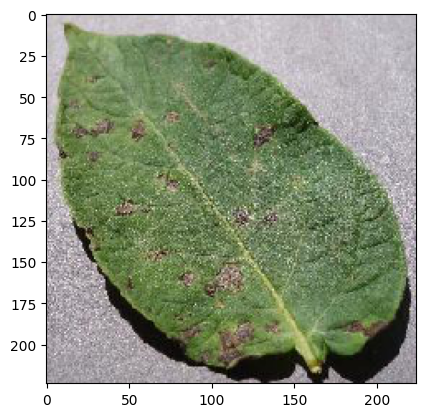

In [ ]:
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded = files.upload()

for image in uploaded.keys():
  img = load_img(image, target_size=(224, 224))
  imgplot = plt.imshow(img)
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch
  predictions = model4.predict(img_array)
  print("predictions : " ,predictions)
  print("predicted label:",classes[np.argmax(predictions)])

Saving early 2.jpg to early 2 (1).jpg
Saving early 3.jpg to early 3 (1).jpg
Saving early 6.jpg to early 6 (1).jpg
Saving early.jpg to early (1).jpg
Saving early4.jpg to early4 (1).jpg
1/1 [==============================] - 0s 31ms/step
predictions :  [[1.0000000e+00 2.8253111e-18 4.6649442e-14]]
predicted label: potato early blight
1/1 [==============================] - 0s 32ms/step
predictions :  [[9.9909842e-01 6.8234307e-08 9.0143806e-04]]
predicted label: potato early blight
1/1 [==============================] - 0s 30ms/step
predictions :  [[9.9922729e-01 3.7801314e-08 7.7274040e-04]]
predicted label: potato early blight
1/1 [==============================] - 0s 33ms/step
predictions :  [[9.5674533e-01 1.2027650e-05 4.3242678e-02]]
predicted label: potato early blight
1/1 [==============================] - 0s 35ms/step
predictions :  [[9.9999249e-01 1.5717788e-07 7.4406548e-06]]
predicted label: potato early blight


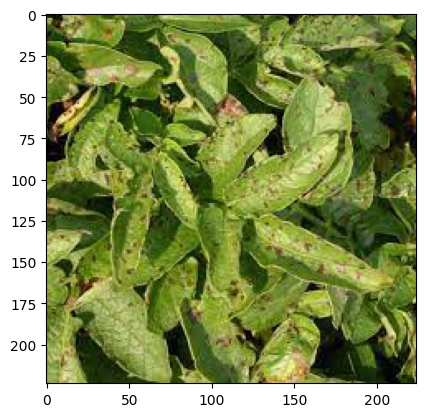

In [ ]:
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded = files.upload()

for image in uploaded.keys():
  img = load_img(image, target_size=(224, 224))
  imgplot = plt.imshow(img)
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch
  predictions = model4.predict(img_array)
  print("predictions : " ,predictions)
  print("predicted label:",classes[np.argmax(predictions)])


Saving late1.jpg to late1 (1).jpg
Saving late2.jpg to late2 (1).jpg
Saving late3.jpg to late3 (1).jpg
Saving late6.jpg to late6 (1).jpg
Saving late7.jpg to late7 (1).jpg
Saving late8.jpg to late8 (1).jpg
1/1 [==============================] - 0s 27ms/step
predictions :  [[9.9999571e-01 3.9018873e-09 4.3467785e-06]]
predicted label: potato early blight
1/1 [==============================] - 0s 27ms/step
predictions :  [[1.4112463e-03 1.2300607e-04 9.9846578e-01]]
predicted label: potato late blight
1/1 [==============================] - 0s 29ms/step
predictions :  [[2.1309368e-06 1.4237365e-07 9.9999774e-01]]
predicted label: potato late blight
1/1 [==============================] - 0s 30ms/step
predictions :  [[9.9986553e-01 1.7182197e-07 1.3430405e-04]]
predicted label: potato early blight
1/1 [==============================] - 0s 28ms/step
predictions :  [[0.09562291 0.00479994 0.89957714]]
predicted label: potato late blight
1/1 [==============================] - 0s 29ms/step
predic

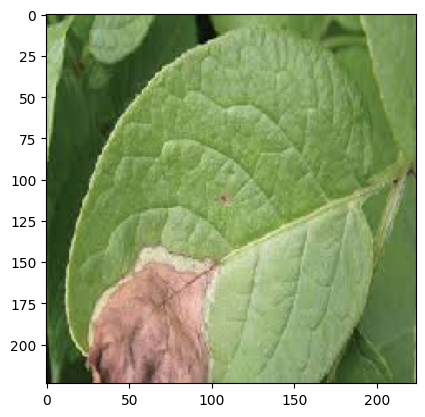

In [ ]:
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded = files.upload()

for image in uploaded.keys():
  img = load_img(image, target_size=(224, 224))
  imgplot = plt.imshow(img)
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch
  predictions = model4.predict(img_array)
  print("predictions : " ,predictions)
  print("predicted label:",classes[np.argmax(predictions)])

Saving 00d8f10f-5038-4e0f-bb58-0b885ddc0cc5___RS_Early.B 8722.JPG to 00d8f10f-5038-4e0f-bb58-0b885ddc0cc5___RS_Early.B 8722.JPG
Saving 0a8a68ee-f587-4dea-beec-79d02e7d3fa4___RS_Early.B 8461.JPG to 0a8a68ee-f587-4dea-beec-79d02e7d3fa4___RS_Early.B 8461.JPG
Saving 0a6983a5-895e-4e68-9edb-88adf79211e9___RS_Early.B 9072.JPG to 0a6983a5-895e-4e68-9edb-88adf79211e9___RS_Early.B 9072.JPG
Saving 0a79700b-f834-41f5-ae51-6ceda6f67a48___RS_Early.B 8951.JPG to 0a79700b-f834-41f5-ae51-6ceda6f67a48___RS_Early.B 8951.JPG
Saving 0c4f6f72-c7a2-42e1-9671-41ab3bf37fe7___RS_Early.B 6752.JPG to 0c4f6f72-c7a2-42e1-9671-41ab3bf37fe7___RS_Early.B 6752.JPG
Saving 0c5b14d9-8b1c-4c39-bb23-1835b5760caa___RS_Early.B 7937.JPG to 0c5b14d9-8b1c-4c39-bb23-1835b5760caa___RS_Early.B 7937.JPG
Saving 0d9dbf50-53a9-42b2-8b29-0360fb7dbd98___RS_Early.B 6692.JPG to 0d9dbf50-53a9-42b2-8b29-0360fb7dbd98___RS_Early.B 6692.JPG
Saving 0d2325ff-4e3e-44bf-9614-e5ad6c23fc16___RS_Early.B 6797.JPG to 0d2325ff-4e3e-44bf-9614-e5ad6c23fc1

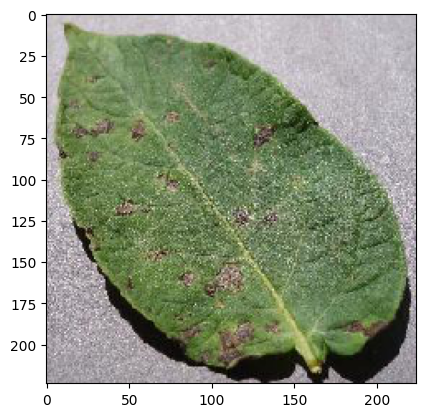

In [ ]:
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded = files.upload()

for image in uploaded.keys():
  img = load_img(image, target_size=(224, 224))
  imgplot = plt.imshow(img)
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch
  predictions = model4.predict(img_array)
  print("predictions : " ,predictions)
  print("predicted label:",classes[np.argmax(predictions)])